# Refactored Simstock demo

## Things to discuss

- Quick overview and basic usage (for end users)
- Overview of some additional features
- Overview of finer grained usage
- Dev notes:
    - Restructuring of code base
    - Developers usage: poetry
    - Changes to algorithms
    - Tests
    - Documentation
- Next steps:
    - Further development
    - Public releases and plugin etc. 

## Quick overview and basic usage 

Simstock broadly does two things: preprocesses data, and then saves it to an idf file. The refactoring has seperated these two actions into two base objects: the ``SimstockDataframe`` and the ``IDFcreator``. Basic workflow:

In [22]:
import simstock as sim

# Read in data
sdf = sim.read_csv("tests/data/test_data.csv")

# Process it
sdf.preprocessing()

# Create and save the IDF object
sim.create_idf(sdf, "tests/data/test.idf")

## Some additional features

Simstock can now read and write from additonal data format: ``json`` and ``parquet``:

In [12]:
sdf = sim.read_parquet("tests/data/test_data.parquet")

The ``SimstockDatafame`` can also be instantiated from a Pandas dataframe:

In [23]:
import pandas as pd 
df = pd.read_csv("tests/data/test_data.csv")
sdf = sim.SimstockDataframe(sdf)

The ``SimstockDataframe`` can be accessed in the same manner as a Pandas dataframe. E.g.

In [24]:
print(sdf.loc[sdf["osgb"] == "osgb1000005307038", "polygon"])

0    POLYGON ((528883.55 186137, 528873.95 186130.9...
Name: polygon, dtype: object


In [25]:
print(sdf.columns)

Index(['polygon', 'osgb', 'shading', 'height', 'wwr', 'nofloors',
       'construction', 'interiors', 'touching', 'polygon_exposed_wall',
       'polygon_horizontal'],
      dtype='object')


We also have some basic plotting ability:

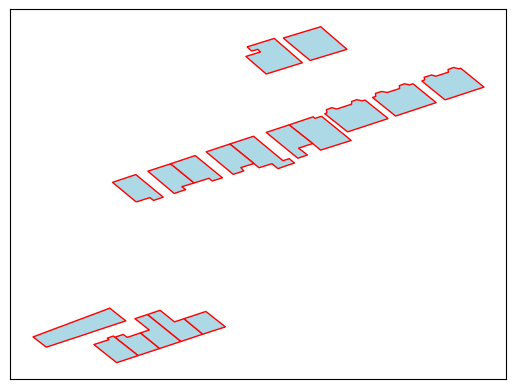

In [26]:
import matplotlib.pyplot as plt

sim.plot(sdf, facecolor="lightblue", edgecolor="red")
plt.show()

## Finer grained control 

``Simstock`` allows fine grained control over the preprocessing and ``IDF`` file creation steps. Interally, ``Simstock`` is based around two objects: 
- The ``SimstockDataframe`` class.
- The ``IDFcreator`` class.

The ``SimstockDataframe`` object is responsible for reading in data and preprocessing it. The ``IDFcreator`` object then computes various data needed for an EnergyPlus run. This data is then stored as an ``IDF`` file or an ``idf`` object for further use within Python. See the following code snippet as an example:

In [20]:
# Set kwargs
kwargs = {"tol" : 0.1}

# Read in data
sdf = sim.read_csv("tests/data/test_data.csv")
 
# Ensure exteriors and interiors are oriented correctly
sdf.orientate_polygons(**kwargs)

# Remove duplicate coordinates from polygons
sdf.remove_duplicate_coords(**kwargs)

# Check for polygons intersecting each other
sdf.polygon_topology(**kwargs)

# Assess which polygons need simplifying
sdf.polygon_tolerance(**kwargs)

# Simplify relevant polygons
sdf.polygon_simplification(**kwargs)

# Check again that polygons are not intersecting each other
sdf.polygon_topology(**kwargs)

# Remove collinear points, determine exterior surfaces coordinates
sdf.collinear_exterior(**kwargs)

# Final check that nothing is interecting after the above processing
# It pays to repeatedly check this
sdf.polygon_topology(**kwargs)

# We now have proprocessed data ready to be turned into an IDF file
# To turn it into an IDF file, we can either call create_idf,
# or instantiate an IDFcreator object for finer grained control:
idfkwargs = {"min_avail_height" : 80}
ob = sim.IDFcreator(sdf)
 
# Move all objects towards origin
ob.move_towards_origin(**idfkwargs)

# Create shading objects
ob.create_shading_objects(**idfkwargs)
 
# Create thermal zones based on floor number
ob.create_thermal_zones(**idfkwargs)

# Compute ideal load systems
ob.create_load_systems(**idfkwargs)

# All relevant data for an E+ run have now been created
# The results can be saved to a file,
# Or kept as an eppy idf object for further processing:
idf = ob.idf

## Dev notes

### Code restructuring

<img src="docs/im1.png" alt= “” width="600" height="500">

Expanded:

<img src="docs/im2.png" alt= “” width="600" height="500">

## Developer's usage: poetry

Recommend installing poetry.

Python can be accessed via

``poetry run python``.

## Changes to algorithms

- The code has been flattened.
- Error messages and exception handling included. E.g. 

```python
def _validate_osgb_column(self) -> None:
        cols = [e for e in self._df.columns if e.casefold() == "osgb"]
        if len(cols) == 0:
            raise KeyError("No \"osgb\" column dectected!\n")
        self._df = self._df.rename(columns={cols[0] : "osgb"})
```

```python
def __init__(self, data, idd_file : str = None, **kwargs) -> None:
    self.__dict__.update(kwargs)

    # Try and load data from simstockdataframe
    try:
        self.get_df(data)
    except TypeError as exc:
        msg = f"Type: {type(data)} cannot be loaded."
        raise TypeError(msg) from exc
    except FileNotFoundError as exc:
        msg = f"File {data} not found."
        raise FileNotFoundError(msg) from exc
    except IOError as exc:
        msg = f"Data in {data} cannot be read."
        raise IOError(msg) from exc
```

- Various validation steps now happen.
- The sytem now automatically finds energy plus, handles system problems.

## Testing

A testing suite is now included via unittests.

```bash
poetry run python -m unittest -b -v
```

## Documentation via pdoc

```bash
poetry run pdoc src/simstock -o docs/
```



# Next steps?

- Release 
- Extensions